### Dependancies used

In [1]:
import sys

sys.path.append("/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection/py")

from functions import *

Hello world


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import ast

from PIL import Image,ImageDraw

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50, ResNet50_Weights


from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
HOME = "/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection"
#HOME = '/content/drive/MyDrive/ACT Coursework 2/Airbus-Aircraft-Detection/'
directory_path = os.path.join(HOME, 'airbus-aircrafts-sample-dataset')
image_path = os.path.join(directory_path, 'images')

### What is data augmentation?

Data augmentation is the process of generating more data out of a pre-existing dataset using various transformations to create new data, which can increase dataset diversity for training a machine learning algorithm.

### Why use data augmentation?

Data augmentation is very useful in situations where gathering more real data has ethical, financial or time restrictions and the current dataset is insufficient for accurate training and the diversity created by the adds more general features that help the model expect differences in features and better prepares it for unseen data which improves its overall performance.

In the case of the AirBus dataset being used, the dataset is quite small and both the desired and undesired features are very repetitive which can lead to overfitting as shown by the loss curve in out neural network.

### Methods of data augmentation

Data augmentation can be performed in a variety of ways to improve model diversity including but not limited to...
- Rotation: rotating images can help the model recognise models at different angles
- Cropping: removing sections of the image can simulate a closer image or focus on a particular feature
- Brightness: changing the brightness of the image can simulate variations in lighting conditions
- Gaussian Noise: adding noise can blur the image and simulate sensor noise and graininess.

Lets demonstrate this by taking a random data sample and using Albumentations to apply a [Gaussian Blur](https://en.wikipedia.org/wiki/Gaussian_blur) transformation to it.

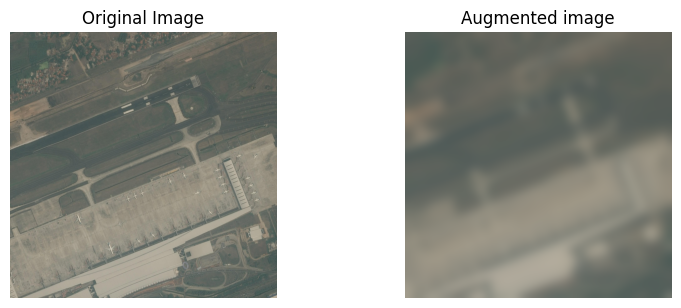

In [6]:
transform = A.Compose([
    A.GaussianBlur(blur_limit=(69, 421), sigma_limit=0, p=1.0),
    ToTensorV2(p=1.0)
])

random_image = np.random.choice(os.listdir(image_path))
image_path2 = os.path.join(image_path, random_image)
image = cv2.imread(image_path2)  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Apply the transformation multiple times
augmented_images = []
for _ in range(1):  # Generate N different augmented images
    augmented = transform(image=image)
    augmented_images.append(augmented['image'].permute(1, 2, 0).numpy())  # Convert back to numpy for visualisation

# Display the original and augmented images
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(augmented_images[0].astype(np.uint8))
plt.title(f"Augmented image")
plt.axis("off")

plt.tight_layout()
plt.show()

Before in the neural network, Albumentations was used to convert the images into tensors so PyTorch could interpret them, this function can be modified to include the aformentiond augmentation processes and create additional images for training using these transformations and to remove potential bias, one transformation will be applied to an image randomly.

In [ ]:
def get_train_transform():
    return A.Compose(
        [A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Apply Gaussian Noise
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),  # Adjust Brightness and Contrast
                A.ChannelShuffle(p=0.2),  # Randomly shuffle image channels
                A.Downscale(scale_min=0.5, scale_max=0.9, interpolation=0, p=0.2),  # Downscale the image pixel size
                ],
                p=1.0,
            ),
            ToTensorV2(p=1.0),  # Convert to PyTorch tensor
        ]
    )

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))